In [2]:
pip install music21

  Obtaining dependency information for music21 from https://files.pythonhosted.org/packages/a1/1b/ef7bdf01df19cc7ac9294531a9c991c6d382bde6bc15c9d106b9a5e547ef/music21-9.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for chardet from https://files.pythonhosted.org/packages/38/6f/f5fbc992a329ee4e0f288c1fe0e2ad9485ed064cac731ed2fe47dcc38cbf/chardet-5.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for jsonpickle from https://files.pythonhosted.org/packages/d3/25/6e0a450430b7aa194b0f515f64820fc619314faa289458b7dfca4a026114/jsonpickle-3.0.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 33.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.7 MB/s eta 0:00:00


In [3]:
import glob
import pickle
import numpy as np
import pandas as pd
import os
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
import keras.utils
from keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# the file is the output of extract_notes.ipynb

notes_output_file = "notes_train.txt"
durations_output_file = "durations_train.txt"

from fractions import Fraction

notes = []
durations = []
with open(notes_output_file, 'r') as notes_file:
    for line in notes_file:
        notes.append(line.strip())

with open(durations_output_file, 'r') as durations_file:
    for line in durations_file:
        duration_str = line.strip()  # Get the duration string
        
        # Check if duration string is a fraction
        if '/' in duration_str:
            # Convert fraction string to float using the Fraction module
            fraction = Fraction(duration_str)
            durations.append(float(fraction))  # Convert Fraction to float
        else:
            # For other representations, try converting to float directly
            try:
                durations.append(float(duration_str))
            except ValueError:
                # If not convertible, keep as string
                durations.append(duration_str)


In [6]:
len(notes), len(durations)

(40705, 40705)

In [7]:
import numpy
sequence_length = 25

# Combine pitch and duration into tuples
combined_notes_durations = list(zip(notes, durations))

# get all unique combined pitch and duration pairs
unique_pairs = sorted(set(item for item in combined_notes_durations))

# create a dictionary to map unique pairs to integers
pair_to_int = {pair: number for number, pair in enumerate(unique_pairs)}

network_input = []
network_output = []

# create input sequences and corresponding outputs
for i in range(0, len(combined_notes_durations) - sequence_length, 1):
    sequence_in = combined_notes_durations[i:i + sequence_length]
    sequence_out = combined_notes_durations[i + sequence_length]

    # map pitches and durations to their integer representations
    network_input.append([pair_to_int[pair] for pair in sequence_in])
    network_output.append(pair_to_int[sequence_out])

n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))

# normalize input
network_input = network_input / float(len(unique_pairs))

# one-hot encode the output (since it represents both pitch and duration)
network_output = keras.utils.to_categorical(network_output, num_classes=len(unique_pairs))

In [22]:
pair_to_int

{('0', 0.25): 0,
 ('0', 0.5): 1,
 ('0', 0.6666666666666666): 2,
 ('0', 0.75): 3,
 ('0', 1.0): 4,
 ('0', 1.25): 5,
 ('0', 1.3333333333333333): 6,
 ('0', 1.5): 7,
 ('0', 1.75): 8,
 ('0', 2.0): 9,
 ('0', 3.0): 10,
 ('0', 3.5): 11,
 ('0', 3.75): 12,
 ('0', 4.0): 13,
 ('0', 5.0): 14,
 ('0', 6.0): 15,
 ('0', 12.0): 16,
 ('0.1.3', 0.25): 17,
 ('0.2', 0.25): 18,
 ('0.2', 0.3333333333333333): 19,
 ('0.2', 0.5): 20,
 ('0.2', 0.75): 21,
 ('0.2', 1.0): 22,
 ('0.2', 1.25): 23,
 ('0.2', 1.75): 24,
 ('0.2', 2.0): 25,
 ('0.2', 2.5): 26,
 ('0.2', 3.75): 27,
 ('0.2', 4.0): 28,
 ('0.2', 4.25): 29,
 ('0.2', 5.0): 30,
 ('0.2.3', 0.25): 31,
 ('0.2.3.5.8', 4.0): 32,
 ('0.2.3.7', 0.5): 33,
 ('0.2.4', 0.25): 34,
 ('0.2.4.7', 3.75): 35,
 ('0.2.4.7', 4.0): 36,
 ('0.2.5', 0.25): 37,
 ('0.2.5', 0.3333333333333333): 38,
 ('0.2.7', 0.25): 39,
 ('0.2.7', 0.3333333333333333): 40,
 ('0.2.7', 0.5): 41,
 ('0.2.7', 2.0): 42,
 ('0.2.7', 4.0): 43,
 ('0.3', 0.25): 44,
 ('0.3', 0.5): 45,
 ('0.3', 1.5): 46,
 ('0.3', 2.0): 47,


In [19]:
len(unique_pairs)

1661

In [9]:
n_vocab= len(unique_pairs)

model = Sequential()
model.add(LSTM(512,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNorm())
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNorm())
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(network_input, network_output, test_size = 0.2, random_state = 0)

In [11]:
filepath = "lastmodel-seq25-val-{epoch:02d}-{loss:.4f}-bigger.h5"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]
history = model.fit(x_train, y_train, epochs=100, batch_size=64, callbacks=callbacks_list, validation_data = (x_test, y_test))

Epoch 1/100
509/509 [==============================] - 23s 27ms/step - loss: 6.0132 - accuracy: 0.0351 - val_loss: 6.0829 - val_accuracy: 0.0286
Epoch 2/100
  4/509 [..............................] - ETA: 10s - loss: 5.8055 - accuracy: 0.0586

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


509/509 [==============================] - 12s 25ms/step - loss: 5.4053 - accuracy: 0.0940 - val_loss: 5.0976 - val_accuracy: 0.1239
Epoch 3/100
509/509 [==============================] - 12s 24ms/step - loss: 4.7340 - accuracy: 0.1754 - val_loss: 4.4548 - val_accuracy: 0.2117
Epoch 4/100
509/509 [==============================] - 12s 25ms/step - loss: 4.2125 - accuracy: 0.2490 - val_loss: 3.9063 - val_accuracy: 0.2930
Epoch 5/100
509/509 [==============================] - 12s 24ms/step - loss: 3.7886 - accuracy: 0.3098 - val_loss: 3.6147 - val_accuracy: 0.3457
Epoch 6/100
509/509 [==============================] - 12s 24ms/step - loss: 3.4638 - accuracy: 0.3658 - val_loss: 3.3471 - val_accuracy: 0.3886
Epoch 7/100
509/509 [==============================] - 12s 24ms/step - loss: 3.1748 - accuracy: 0.4141 - val_loss: 3.1697 - val_accuracy: 0.4227
Epoch 8/100
509/509 [==============================] - 12s 25ms/step - loss: 2.9652 - accuracy: 0.4529 - val_loss: 3.0589 - val_accuracy: 0.44

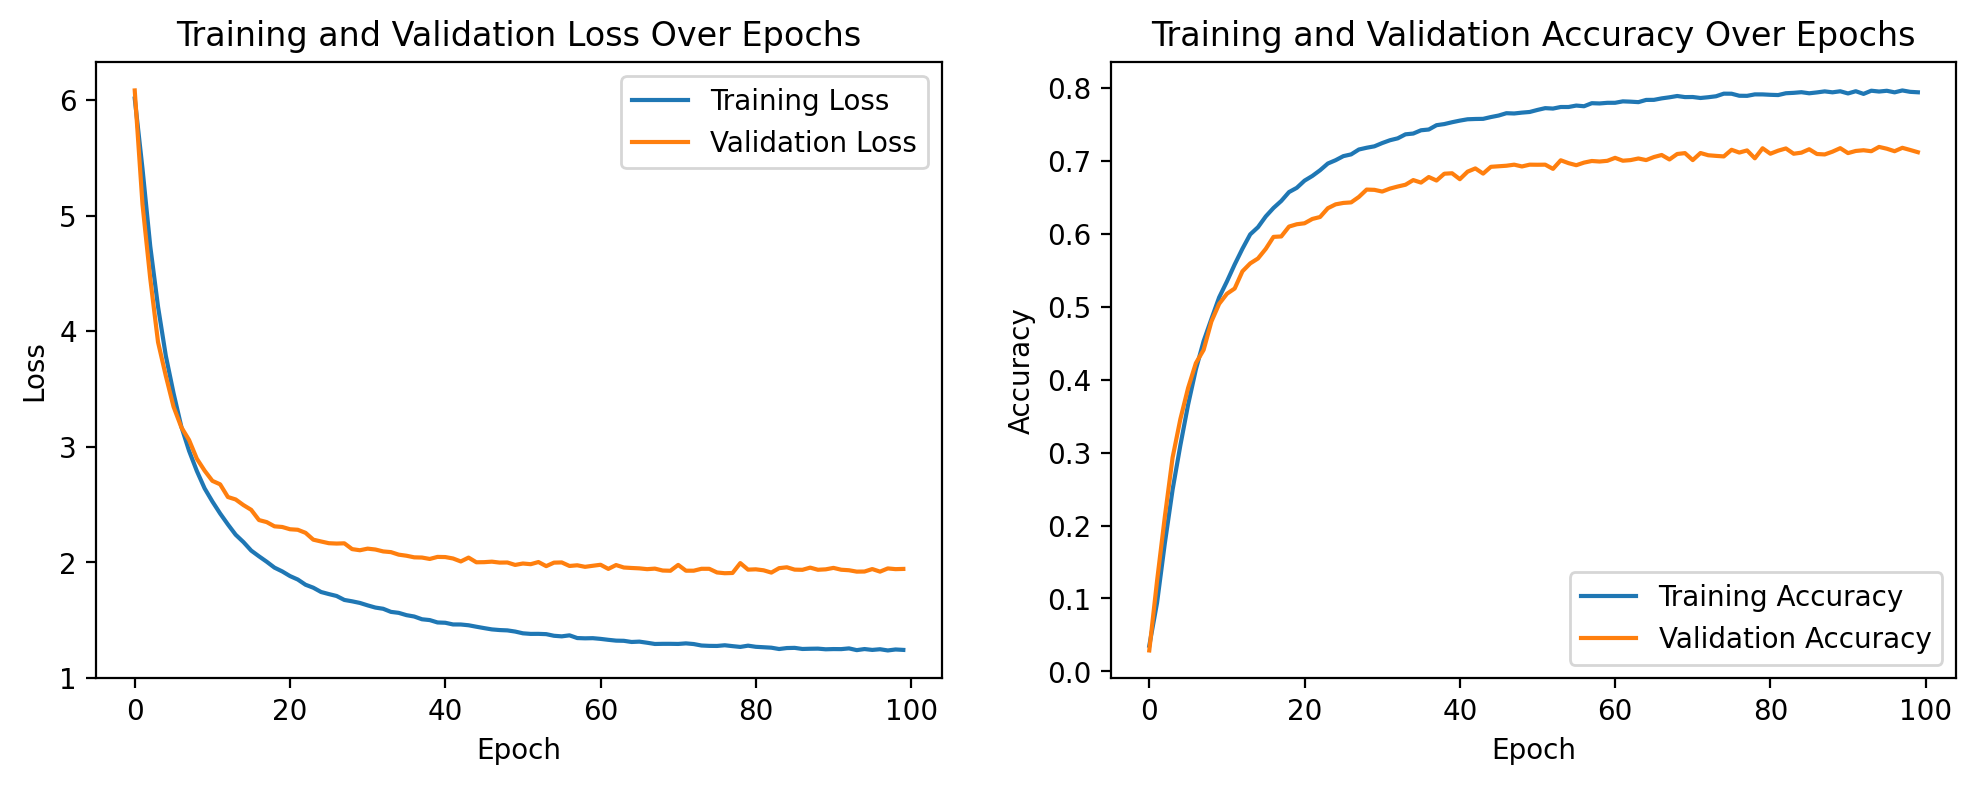

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming model is a TensorFlow model and you've trained it with model.fit()
history = model.history.history

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [13]:
filepath = "lastbnmodel-seq25-{epoch:02d}-{loss:.4f}-bigger.h5"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]
history = model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)

Epoch 1/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4711 - accuracy: 0.7602
Epoch 2/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4557 - accuracy: 0.7582
Epoch 3/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4590 - accuracy: 0.7584
Epoch 4/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4535 - accuracy: 0.7574
Epoch 5/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4417 - accuracy: 0.7605
Epoch 6/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4368 - accuracy: 0.7608
Epoch 7/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4237 - accuracy: 0.7616
Epoch 8/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4168 - accuracy: 0.7630
Epoch 9/100
636/636 [==============================] - 14s 22ms/step - loss: 1.4172 - accuracy: 0.7623
Epoch 10/100
636/636 [==============================] - 14s 22ms/step - l

In [14]:
import pickle

# Open a file and use dump() 
with open('history-train-full.h5', 'wb') as file: 
    pickle.dump(history, file)
    
model.save("lstm-train-full.h5")
    
with open("pair_to_int-train-full.pkl", "wb") as file:
    pickle.dump(pair_to_int, file)

In [15]:
from music21 import note, stream, duration, midi

# Create a reverse dictionary to map integers back to combined note-duration pairs
int_to_pair = {number: pair for pair, number in pair_to_int.items()}

start = numpy.random.randint(0, len(network_input)-1)
pattern = network_input[start]

prediction_output = []

# generate notes
for note_index in range(100):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction = model.predict(prediction_input, verbose=0)
    index = numpy.argmax(prediction)
    
    result = int_to_pair[index]  # Retrieve the note-duration pair from the integer index
    prediction_output.append(result)
    
    # Update pattern for the next iteration
    to_append = index / float(len(unique_pairs))
    pattern = numpy.append(pattern, [[to_append]], axis=0)
    pattern = pattern[1:len(pattern)]

In [16]:
output_stream = stream.Stream()

# Create note and duration objects and append them to output_notes
for pattern in prediction_output:
    note_pitch, note_duration = pattern

    # Check if the note_pitch is a float (representing a note duration) and handle accordingly
    if isinstance(note_pitch, float):
        # Assuming the previous note was a chord, end it and start a new note with a duration
        output_stream[-1].duration.quarterLength = note_pitch
    else:
        if '.' in note_pitch:  # If it's a chord
            notes_in_chord = note_pitch.split('.')
            chord_notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.duration.quarterLength = note_duration
                chord_notes.append(new_note)
            new_chord = chord.Chord(chord_notes)
            output_stream.append(new_chord)
        else:  # If it's a single note
            try:
                new_note = note.Note(note_pitch)
                new_note.duration.quarterLength = note_duration
                output_stream.append(new_note)
            except Exception as e:
                pass

# Write the MIDI file
midi_stream = midi.translate.music21ObjectToMidiFile(output_stream)
midi_stream.open('generated_music.mid', 'wb')
midi_stream.write()
midi_stream.close()

In [17]:
prediction_output

[('11.2', 1.0),
 ('11.2', 1.0),
 ('A2', 1.0),
 ('4.9', 0.25),
 ('A2', 1.0),
 ('4.9', 0.25),
 ('A2', 1.0),
 ('D5', 5.0),
 ('G2', 0.25),
 ('G2', 1.0),
 ('D2', 0.5),
 ('G#4', 0.25),
 ('7', 5.0),
 ('G2', 1.0),
 ('A3', 0.25),
 ('F#5', 0.5),
 ('F3', 0.25),
 ('A4', 0.5),
 ('5.8', 0.5),
 ('C5', 0.25),
 ('G2', 0.25),
 ('7.11', 1.0),
 ('C5', 0.5),
 ('B4', 0.25),
 ('C5', 0.25),
 ('B-3', 0.25),
 ('F4', 0.5),
 ('D5', 2.0),
 ('E3', 0.25),
 ('E-5', 0.25),
 ('C4', 0.5),
 ('E3', 0.75),
 ('G5', 0.25),
 ('F#4', 0.25),
 ('B4', 1.0),
 ('D4', 0.5),
 ('G5', 0.25),
 ('F5', 1.0),
 ('E3', 0.25),
 ('F5', 0.25),
 ('C#4', 0.75),
 ('B5', 0.25),
 ('E-2', 0.3333333333333333),
 ('E5', 4.0),
 ('B-3', 0.5),
 ('D4', 0.5),
 ('G#3', 0.3333333333333333),
 ('D3', 0.5),
 ('F5', 0.25),
 ('D3', 0.5),
 ('F5', 0.25),
 ('E-5', 0.5),
 ('D5', 0.25),
 ('G5', 0.25),
 ('F4', 0.25),
 ('D3', 0.25),
 ('C4', 0.5),
 ('E-4', 0.5),
 ('B-3', 0.5),
 ('B-3', 0.5),
 ('F5', 0.25),
 ('E5', 0.08333333333333333),
 ('C5', 0.25),
 ('F4', 0.75),
 ('G4',

Testing dilakukan di https://final-project-deep-learning.streamlit.app/, dengan script ada di App.py